In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
import ast
import torch
from sklearn.decomposition import PCA
from joblib import dump, load

In [2]:
df_train = pd.read_csv('database/LaA_train.csv')
df_test = pd.read_csv('database/LaA_test.csv')
df_train.head(10)[['artist_name','track_name','emotion','label']]

,artist_name,track_name,emotion,label
0,Alexz Johnson,White Lines,Relaxed,2
1,Turntablerocker,No Melody,Relaxed,2
2,Lamb,Zero,Sad,3
3,Einstuerzende Neubauten,Youme & Meyou,Relaxed,2
4,Mouse On Mars,Wipe That Sound,Happy,1
5,Yeasayer,Germs,Happy,1
6,Dire Straits,Walk Of Life,Happy,1
7,Phantom Planet,All Over Again,Happy,1
8,David Cook,Lie,Sad,3
9,Michael Bolton,When I'm Back On My Feet Again,Happy,1


### Balance of the data set

Text(0, 0.5, 'Arousal')

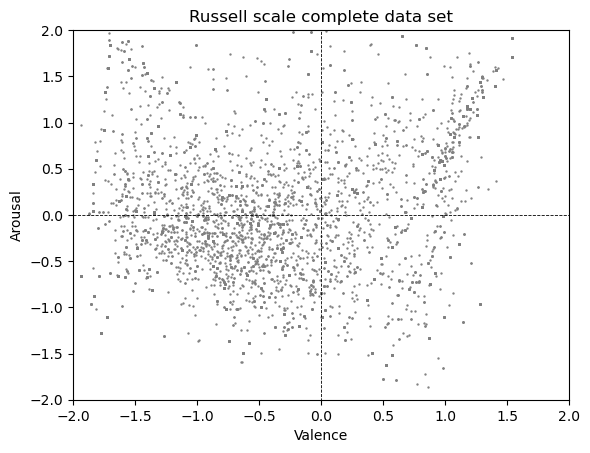

In [3]:
plt.scatter(df_test['valence'],df_test['arousal'], color='gray',s = 0.5)
plt.scatter(df_train['valence'],df_train['arousal'], color='gray',s = 0.5)
plt.title('Russell scale complete data set')
plt.vlines(0,-3,3, ls='--', color='k', lw= 0.6)
plt.hlines(0,-2,3, ls='--', color='k', lw= 0.6)
plt.xlim(-2,2)
plt.ylim(-2,2)

plt.xlabel('Valence')
plt.ylabel('Arousal')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


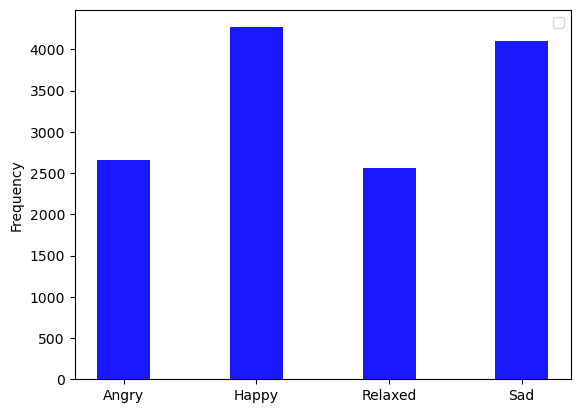

In [88]:
labels = ['Angry', 'Happy', 'Relaxed', 'Sad']

histogram = pd.concat([df_train, df_test])['emotion'].value_counts().reindex(labels)
#plt.grid()
plt.bar(labels, histogram, color = 'b', alpha = 0.9, width=0.4)
plt.ylabel('Frequency')
plt.legend()

In [7]:
embeddings_audio_train = df_train['audio_embedding'].apply(ast.literal_eval).apply(np.array)
x_audio_train = np.stack(embeddings_audio_train.values)
embeddings_audio_test = df_test['audio_embedding'].apply(ast.literal_eval).apply(np.array)
x_audio_test = np.stack(embeddings_audio_test.values)

embeddings_lyrics_train = df_train['lyrics_embedding'].apply(ast.literal_eval).apply(np.array)
x_lyrics_train = np.stack(embeddings_lyrics_train.values)
embeddings_lyrics_test = df_test['lyrics_embedding'].apply(ast.literal_eval).apply(np.array)
x_lyrics_test = np.stack(embeddings_lyrics_test.values)

y_train = df_train['label']
y_test = df_test['label']

In [8]:
name_svm_audio = 'models/SVM_audio.joblib'
name_svm_lyrics = 'models/SVM_lyrics.joblib'
svm_classifier_audio = load(name_svm_audio)
svm_classifier_lyrics = load(name_svm_lyrics)

In [9]:
# Predict the probabilities
y_pred_test_prob_lyrics = svm_classifier_lyrics.predict_proba(x_lyrics_test)
y_pred_test_prob_audio = svm_classifier_audio.predict_proba(x_audio_test)
y_pred_train_prob_lyrics = svm_classifier_lyrics.predict_proba(x_lyrics_train)
y_pred_train_prob_audio = svm_classifier_audio.predict_proba(x_audio_train)

# Calculate accuracy
y_pred_lyrics = np.argmax(y_pred_test_prob_lyrics, axis=1)
y_pred_audio = np.argmax(y_pred_test_prob_audio, axis=1)

acc_lyrics, acc_audio = accuracy_score(y_test, y_pred_lyrics), accuracy_score(y_test, y_pred_audio)
print(f"Lyrics accuracy: {acc_lyrics:.2f}")
print(f"Audio accuracy: {acc_audio:.2f}")

Lyrics accuracy: 0.43
Audio accuracy: 0.42


In [10]:
y_pred_test_prob_lyrics

array([[0.17848826, 0.35416795, 0.27898303, 0.18836076],
       [0.22026447, 0.40716662, 0.1590281 , 0.21354081],
       [0.23652193, 0.3057075 , 0.14658746, 0.31118311],
       ...,
       [0.09682987, 0.68620745, 0.14540973, 0.07155295],
       [0.21646506, 0.19687375, 0.2114823 , 0.37517889],
       [0.20635405, 0.19684176, 0.48161131, 0.11519289]])

### Confusion matrix and ROC curve for lyrics

In [92]:
#Function computing the TNR, FPR, FNR, TPR from the confusion matrix
def metrics_rates(conf_matrix, labels):
    metrics = {}

    for i, label in enumerate(labels):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP
        TN = np.sum(conf_matrix) - TP - FP - FN

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        FNR = FN / (FN + TP)
        TNR = TN / (TN + FP)

        metrics[label] = {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN, 'FPR': FPR, 'TPR': TPR, 'FNR':FNR, 'TNR':TNR}
    return metrics

In [93]:
confusion_matrix_lyrics = np.array(confusion_matrix(y_test, y_pred_lyrics))
print("Confusion Matrix Lyrics:")
print(confusion_matrix_lyrics)

Confusion Matrix Lyrics:
[[ 80 173   7 272]
 [ 27 561  20 246]
 [ 11 261  23 217]
 [ 52 245  23 500]]


Angry: TP=80, FP=90, TN=2096, FN=452, FPR=0.04117108874656908, TPR=0.15037593984962405
Happy: TP=561, FP=679, TN=1185, FN=293, FPR=0.3642703862660944, TPR=0.6569086651053864
Relaxed: TP=23, FP=50, TN=2156, FN=489, FPR=0.022665457842248413, TPR=0.044921875
Sad: TP=500, FP=735, TN=1163, FN=320, FPR=0.38724973656480505, TPR=0.6097560975609756


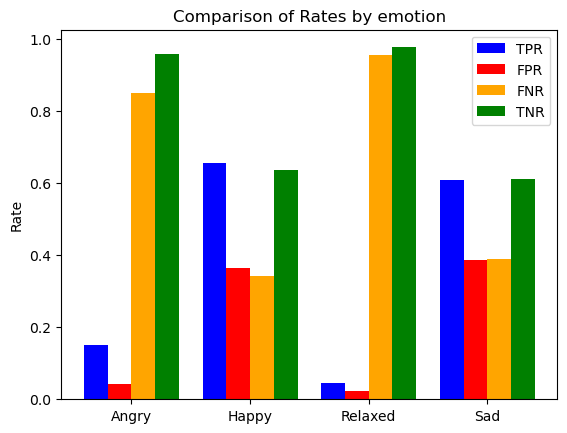

In [94]:
labels = ['Angry', 'Happy', 'Relaxed', 'Sad']

metrics = metrics_rates(confusion_matrix_lyrics, labels)
for label, values in metrics.items():
    print(f"{label}: TP={values['TP']}, FP={values['FP']}, TN={values['TN']}, FN={values['FN']}, FPR={values['FPR']}, TPR={values['TPR']}")
 #   print(values['TPR']+values['FNR'])
#    print(values['TNR']+values['FPR'])


tpr_values = [metrics[label]['TPR'] for label in labels]
fpr_values = [metrics[label]['FPR'] for label in labels]
fnr_values = [metrics[label]['FNR'] for label in labels]
tnr_values = [metrics[label]['TNR'] for label in labels]

#Plot the rates per emotion
width = 0.2
x = np.arange(len(labels))
plt.bar(x - 1.5*width, tpr_values, width, label='TPR', color='blue')
plt.bar(x - 0.5*width, fpr_values, width, label='FPR', color='red')
plt.bar(x + 0.5*width, fnr_values, width, label='FNR', color='orange')
plt.bar(x + 1.5*width, tnr_values, width, label='TNR', color='green')

plt.ylabel('Rate')
plt.title('Comparison of Rates by emotion')
plt.xticks(x, labels)
plt.legend()
plt.show()

In order to analyse the classifier performance with the specific emotions, the ROC curve and confussion matrix are going to be evaluated independently

In [114]:
def ROC_curve(y_test, y_pred_test_prob):  # Compute ROC curve for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(4):
        fpr[i], tpr[i], thresholds = roc_curve(y_test.values == i, y_pred_test_prob[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    optimal_thresholds = {}
    optimal_tprs = {}
    optimal_fprs = {}

    # Calculate Youden's J statistic for each label
    for label in fpr.keys():
        J = tpr[label] - fpr[label]
        # Find the index of the maximum J value, max tpr with min fpr
        optimal_threshold_index = np.argmax(J)
        optimal_threshold = thresholds[optimal_threshold_index]
        # Get the corresponding TPR and FPR
        optimal_tpr = tpr[label][optimal_threshold_index]
        optimal_fpr = fpr[label][optimal_threshold_index]
        # Save the optimal threshold and corresponding TPR and FPR
        optimal_thresholds[label] = optimal_threshold
        optimal_tprs[label] = optimal_tpr
        optimal_fprs[label] = optimal_fpr
    return fpr, tpr, optimal_tprs, optimal_fprs, roc_auc

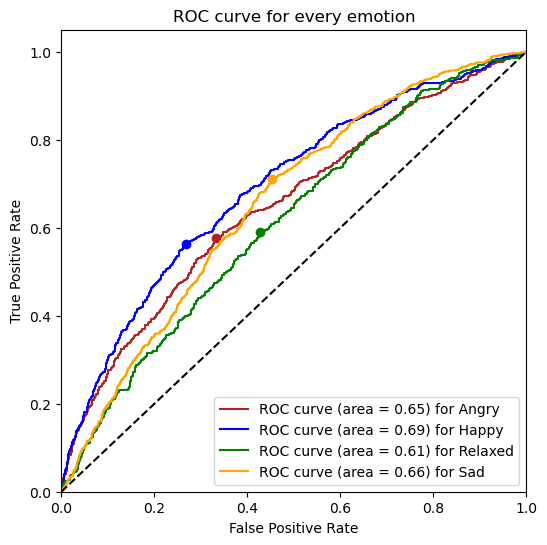

In [115]:
#Angry: 0
#Happy: 1
#Relaxed: 2
#Sad: 3
fpr, tpr, optimal_tprs, optimal_fprs,roc_auc = ROC_curve(y_test, y_pred_test_prob_lyrics)

# Plot ROC curve for each class
plt.figure(figsize=(6, 6))

color = ['firebrick','blue','green','orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], c=color[i],label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]}')
    plt.plot(optimal_fprs[i],optimal_tprs[i], 'o', c=color[i])#, label='Optimal point')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for every emotion')
plt.legend(loc="lower right")
plt.show()

## Confusion matrix and ROC curve for audio

In [75]:
confusion_matrix_audio = np.array(confusion_matrix(y_test, y_pred_audio))
print("Confusion Matrix:")
print(confusion_matrix_audio)

Confusion Matrix:
[[108 195  21 208]
 [ 44 553  38 219]
 [ 20 218  55 219]
 [ 73 280  34 433]]


Angry: TP=108, FP=137, TN=2049, FN=424, FPR=0.0626715462031107, TPR=0.20300751879699247
Happy: TP=553, FP=693, TN=1171, FN=301, FPR=0.3717811158798283, TPR=0.6475409836065574
Relaxed: TP=55, FP=93, TN=2113, FN=457, FPR=0.04215775158658205, TPR=0.107421875
Sad: TP=433, FP=646, TN=1252, FN=387, FPR=0.3403582718651212, TPR=0.5280487804878049


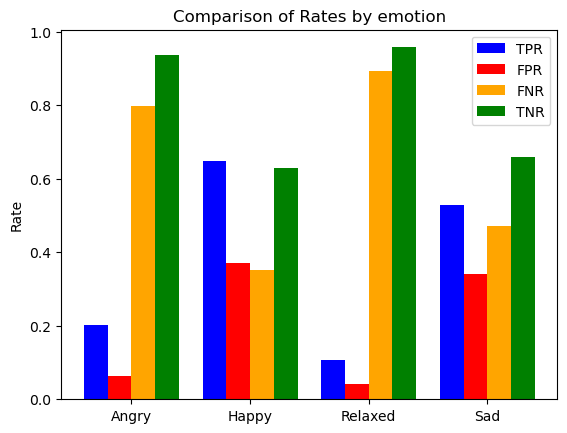

In [101]:
metrics = metrics_rates(confusion_matrix_audio, labels)

for label, values in metrics.items():
    print(f"{label}: TP={values['TP']}, FP={values['FP']}, TN={values['TN']}, FN={values['FN']}, FPR={values['FPR']}, TPR={values['TPR']}")

tpr_values = [metrics[label]['TPR'] for label in labels]
fpr_values = [metrics[label]['FPR'] for label in labels]
fnr_values = [metrics[label]['FNR'] for label in labels]
tnr_values = [metrics[label]['TNR'] for label in labels]

# Set the width of the bars
width = 0.2

x = np.arange(len(labels))

plt.bar(x - 1.5*width, tpr_values, width, label='TPR', color='blue')
plt.bar(x - 0.5*width, fpr_values, width, label='FPR', color='red')
plt.bar(x + 0.5*width, fnr_values, width, label='FNR', color='orange')
plt.bar(x + 1.5*width, tnr_values, width, label='TNR', color='green')

plt.ylabel('Rate')
plt.title('Comparison of Rates by emotion')
plt.xticks(x, labels)
plt.legend()
plt.show()  

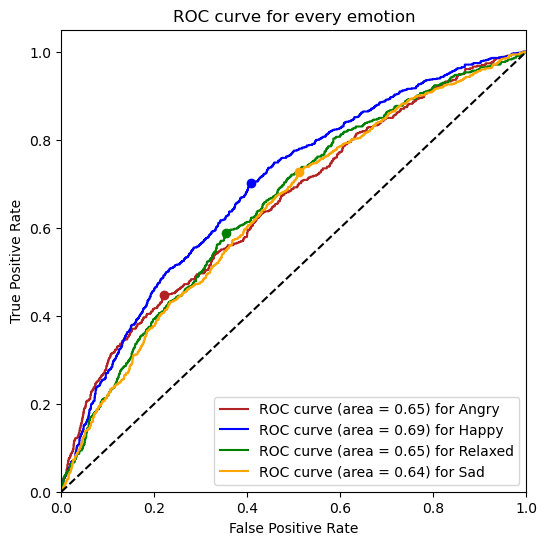

In [102]:
fpr, tpr, optimal_tprs, optimal_fprs,roc_auc = ROC_curve(y_test, y_pred_test_prob_audio)

# Plot ROC curve for each class
plt.figure(figsize=(6, 6))
color = ['firebrick','blue','green','orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], c=color[i],label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]}')
    plt.plot(optimal_fprs[i],optimal_tprs[i], 'o', c=color[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for every emotion')
plt.legend(loc="lower right")
plt.show()

## Confusion matrix and ROC curve for the bimodular

In [69]:
np.maximum(y_pred_test_prob_lyrics, y_pred_test_prob_audio)

array([[0.44420008, 0.35416795, 0.27898303, 0.18836076],
       [0.30270825, 0.40716662, 0.1590281 , 0.2435934 ],
       [0.23652193, 0.33227842, 0.16061832, 0.32198797],
       ...,
       [0.18046535, 0.68620745, 0.14540973, 0.43494566],
       [0.21646506, 0.21860762, 0.2114823 , 0.47793948],
       [0.20635405, 0.35281442, 0.48161131, 0.23007605]])

In [110]:
# Predict the probabilities. Take the maximum probability between the 2 models
y_pred_max_combined = np.argmax(np.maximum(y_pred_test_prob_lyrics, y_pred_test_prob_audio), axis=1)
acc_max_combined = accuracy_score(y_test, y_pred_max_combined)
print(f"Accuracy: {acc_max_combined:.2f}")

Accuracy: 0.45


In [106]:
confusion_matrix_comb = np.array(confusion_matrix(y_test, y_pred_max))
print("Confusion Matrix Combined:")
print(confusion_matrix_comb)

Confusion Matrix Combined:
[[ 90 190  12 240]
 [ 27 610  26 191]
 [  9 256  25 222]
 [ 54 249  19 498]]


Angry: TP=90, FP=90, TN=2096, FN=442, FPR=0.04117108874656908, TPR=0.16917293233082706
Happy: TP=610, FP=695, TN=1169, FN=244, FPR=0.3728540772532189, TPR=0.7142857142857143
Relaxed: TP=25, FP=57, TN=2149, FN=487, FPR=0.025838621940163193, TPR=0.048828125
Sad: TP=498, FP=653, TN=1245, FN=322, FPR=0.3440463645943098, TPR=0.6073170731707317


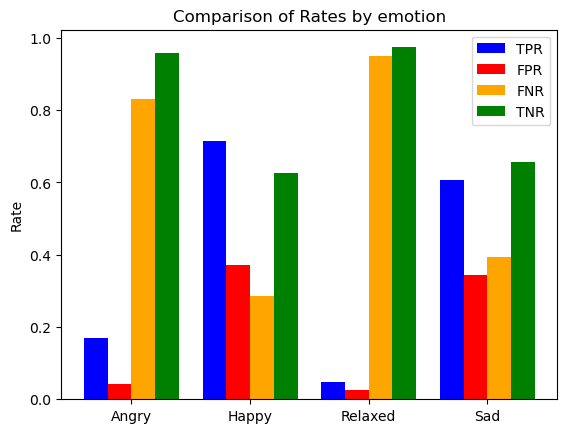

In [107]:
metrics = metrics_rates(confusion_matrix_comb, labels)

for label, values in metrics.items():
    print(f"{label}: TP={values['TP']}, FP={values['FP']}, TN={values['TN']}, FN={values['FN']}, FPR={values['FPR']}, TPR={values['TPR']}")

tpr_values = [metrics[label]['TPR'] for label in labels]
fpr_values = [metrics[label]['FPR'] for label in labels]
fnr_values = [metrics[label]['FNR'] for label in labels]
tnr_values = [metrics[label]['TNR'] for label in labels]

# Set the width of the bars
width = 0.2

x = np.arange(len(labels))

plt.bar(x - 1.5*width, tpr_values, width, label='TPR', color='blue')
plt.bar(x - 0.5*width, fpr_values, width, label='FPR', color='red')
plt.bar(x + 0.5*width, fnr_values, width, label='FNR', color='orange')
plt.bar(x + 1.5*width, tnr_values, width, label='TNR', color='green')

plt.ylabel('Rate')
plt.title('Comparison of Rates by emotion')
plt.xticks(x, labels)
plt.legend()

plt.show()  

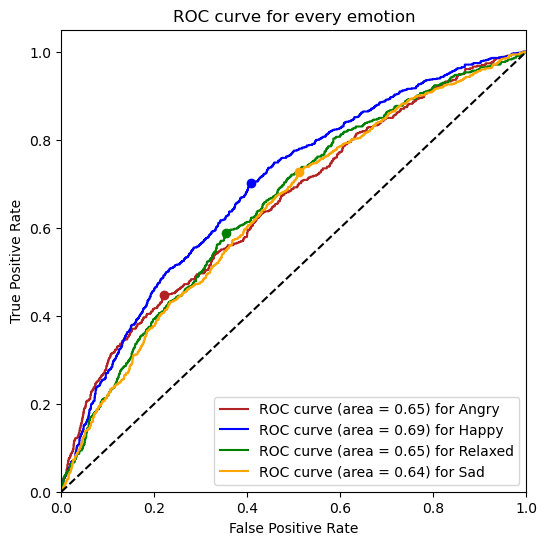

In [108]:
fpr, tpr, optimal_tprs, optimal_fprs,roc_auc = ROC_curve(y_test, y_pred_test_prob_audio)
    
# Plot ROC curve for each class
plt.figure(figsize=(6, 6))

color = ['firebrick','blue','green','orange']
for i in range(4):
    plt.plot(fpr[i], tpr[i], c=color[i],label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]}')
    plt.plot(optimal_fprs[i],optimal_tprs[i], 'o', c=color[i])#, label='Optimal point')
 #   plt.plot(fpr_values[i],tpr_values[i], 'o', c=color[i], alpha = 0.5)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for every emotion')
plt.legend(loc="lower right")
plt.show()

### Check on how many labels the two models differ (per emotion)

In [111]:
results = {}
emotion_map = {0: 'Angry', 1: 'Happy', 2: 'Relaxed', 3: 'Sad'}

total_correct = 0
total_possible = 0

for emotion in [0,1,2,3]:
    emotion_mask = y_test == emotion
    audio_correct = y_pred_audio == y_test
    lyrics_correct = y_pred_lyrics == y_test
    comb_correct = y_pred_max_combined == y_test
    
    both_correct = np.logical_and(audio_correct, lyrics_correct) & emotion_mask
    audio_only_correct = np.logical_and(audio_correct, np.logical_not(lyrics_correct)) & emotion_mask
    lyrics_only_correct = np.logical_and(lyrics_correct, np.logical_not(audio_correct)) & emotion_mask
    
    results[emotion] = {
        'both_agree_and_correct': np.mean(both_correct[emotion_mask]),
        'audio_correct_lyrics_wrong': np.mean(audio_only_correct[emotion_mask]),
        'lyrics_correct_audio_wrong': np.mean(lyrics_only_correct[emotion_mask]),
        'comb_correct': np.mean(comb_correct[emotion_mask]),
    }
    correct_predictions = np.logical_or(both_correct, np.logical_or(audio_only_correct, lyrics_only_correct))

    # Calculate the total number of correct predictions and the total number of possible correct predictions
    total_correct += np.sum(correct_predictions)
    total_possible += np.sum(emotion_mask)


for emotion, result in results.items():
    print(f"Emotion {emotion_map[emotion]}:")
    print(f"  Both Agree & Correct: (Lower bound for combination) {result['both_agree_and_correct']:.2f}")
    print(f"  Audio Correct, Lyrics Wrong: {result['audio_correct_lyrics_wrong']:.2f}")
    print(f"  Lyrics Correct, Audio Wrong: {result['lyrics_correct_audio_wrong']:.2f}")
    print(f"  Upper Bound Correct: {np.sum([result['both_agree_and_correct'], result['audio_correct_lyrics_wrong'], result['lyrics_correct_audio_wrong']]):.2f}")
    print(f"  Combined Correct: {result['comb_correct']:.2f}\n")

# Calculate and print the overall estimated upper bound accuracy
upper_bound_accuracy = total_correct / total_possible
print(f"Estimated Upper Bound Accuracy: {upper_bound_accuracy:.2f}")
print(f"Our accuracy: {acc_max_combined:.2f}")

Emotion Angry:
  Both Agree & Correct: (Lower bound for combination) 0.05
  Audio Correct, Lyrics Wrong: 0.15
  Lyrics Correct, Audio Wrong: 0.10
  Upper Bound Correct: 0.30
  Combined Correct: 0.17

Emotion Happy:
  Both Agree & Correct: (Lower bound for combination) 0.45
  Audio Correct, Lyrics Wrong: 0.20
  Lyrics Correct, Audio Wrong: 0.21
  Upper Bound Correct: 0.86
  Combined Correct: 0.71

Emotion Relaxed:
  Both Agree & Correct: (Lower bound for combination) 0.01
  Audio Correct, Lyrics Wrong: 0.10
  Lyrics Correct, Audio Wrong: 0.04
  Upper Bound Correct: 0.14
  Combined Correct: 0.05

Emotion Sad:
  Both Agree & Correct: (Lower bound for combination) 0.35
  Audio Correct, Lyrics Wrong: 0.18
  Lyrics Correct, Audio Wrong: 0.26
  Upper Bound Correct: 0.79
  Combined Correct: 0.61

Estimated Upper Bound Accuracy: 0.59
Our accuracy: 0.45


### 2. Check how certain the models are about their decisions for each emotion, depending on if they are right or wrong

In [113]:
def analyze_model_confidence(y_test, y_pred_probs, y_pred, emotion_labels):
    correct_confidences = {emotion: [] for emotion in emotion_labels}
    incorrect_confidences = {emotion: [] for emotion in emotion_labels}
    
    # Iterate through predictions and true labels
    for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
        # Confidence for the predicted label
        confidence = y_pred_probs[i][pred_label]
        
        # Correct predictions
        if true_label == pred_label:
            correct_confidences[true_label].append(confidence)
        # Incorrect predictions
        else:
            incorrect_confidences[true_label].append(confidence)
    
    # Calculate average confidences
    average_confidences = {
        'correct': {emotion: np.mean(correct_confidences[emotion]) if correct_confidences[emotion] else 0 for emotion in emotion_labels},
        'incorrect': {emotion: np.mean(incorrect_confidences[emotion]) if incorrect_confidences[emotion] else 0 for emotion in emotion_labels}
    }
    
    return average_confidences

# Example usage
emotion_labels = np.unique(y_test)  # Assuming y_test is available
y_pred_audio = np.argmax(y_pred_test_prob_audio, axis=1)
y_pred_lyrics = np.argmax(y_pred_test_prob_lyrics, axis=1)

# Analyze confidence for audio model
audio_confidence_analysis = analyze_model_confidence(y_test, y_pred_test_prob_audio, y_pred_audio, emotion_labels)
# Analyze confidence for lyrics model
lyrics_confidence_analysis = analyze_model_confidence(y_test, y_pred_test_prob_lyrics, y_pred_lyrics, emotion_labels)

print("Audio Model Confidence Analysis:")
print(f"Average max confidence scores for being correct, audio model: {audio_confidence_analysis['correct']}")
print(f"Average max confidence scores for being wrong, audio model: {audio_confidence_analysis['incorrect']}")
print("\nLyrics Model Confidence Analysis:")
print(f"Average max confidence scores for being correct, lyrics model: {lyrics_confidence_analysis['correct']}")
print(f"Average max confidence scores for being wrong, lyrics model: {lyrics_confidence_analysis['incorrect']}")

Audio Model Confidence Analysis:
Average max confidence scores for being correct, audio model: {0: 0.4167662697520924, 1: 0.4504353569941316, 2: 0.39567908844332533, 3: 0.4293767599349448}
Average max confidence scores for being wrong, audio model: {0: 0.4148378869508925, 1: 0.39847164406373264, 2: 0.41810086648634354, 3: 0.4124235778460077}

Lyrics Model Confidence Analysis:
Average max confidence scores for being correct, lyrics model: {0: 0.40639035632802695, 1: 0.4664761378819228, 2: 0.3782188084371065, 3: 0.4125513084792898}
Average max confidence scores for being wrong, lyrics model: {0: 0.41377799912330904, 1: 0.39310438883474647, 2: 0.4196397185700615, 3: 0.40259646146884653}


### References for the database:
MUSIC MOOD DETECTION BASED ON AUDIO AND LYRICS WITH DEEP NEURAL NET. Rémi Delbouys, Romain Hennequin, Francesco Piccoli, Jimena Royo-Letelier, Manuel Moussallam.
https://github.com/deezer/deezer_mood_detection_dataset 